In [1]:
"""
This program generates Figure 2 of "COVID Risk Narratives"
Author: Yuting Chen
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate, optimize


def turning_points(y,window):
    dy = np.diff(y)
    dy = [np.nan]+list(dy)
    turningpoints = []
    turningscales = []
    for i in range(0,len(dy)):
        try:
            # change from negative trend to positive trend, only the first point around a turn was recorded
            if (np.mean(dy[i-window:i])<0 and np.mean(dy[i:i+window])>0
               ) and (dy[i+1]>0 and dy[i]<0): 
                turningpoints.append(i+1)
                scale = (abs(np.cumprod(np.array(dy[i-window:i])+1,dtype=float)[-1])+abs(np.cumprod(np.array(dy[i:i+window])+1, dtype=float)[-1]))/window
                scale = 1- 1/(1 + np.exp(-scale))
                turningscales.append(scale)
        except:
            None
    return turningpoints,turningscales


# SIR model
def sir_model(y, x, beta, gamma, sigma):
    S = -beta * y[0] * y[1] / 1 + sigma*y[2]
    R = gamma * y[1] - sigma*y[2]
    I = -(S + R)    
    return S, I, R

# SIR DGP
def sir_sigma_dgp(S,I,R,beta,gamma,sigma):
    dS = -beta * S * I + sigma*R
    dR = gamma * I - sigma*R
    dI = -(dS +dR)
    return S+dS, I+dI, R+dR

# SIR turning points
def sir_turning (y,turningpoints,turningscales,model):
    l_beta = []
    l_gamma = []
    l_sigma = []
    Rt = 0 # for the first run, R0 is zero, the later ones are half of the last observation

    I_m = []
    R_m = []
    S_m = []
    
    dy = np.diff(y)
    dy = [np.nan]+list(dy)
    
    for t in range(0,len(turningpoints)+1):
        print(t)
        try:
            if t == 0:
                y_sub = y[0:turningpoints[t]]
            elif t == len(turningpoints):
                y_sub = y[turningpoints[t-1]:]
            else:
                y_sub = y[turningpoints[t-1]:turningpoints[t]]
        # if there is no turning points
        except:
            y_sub = y
         
        x_sub = np.linspace(0, len(y_sub), len(y_sub))
        I0 = y_sub[0]

        if I0 == 0:
            I0 = 0.0001
        R0 = Rt
        S0 = 1-I0-R0

        try:
            def fit_odeint(x, beta, gamma, sigma):
                return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma, sigma))[:,1]
            popt, pcov = optimize.curve_fit(fit_odeint, x_sub, y_sub,bounds=((0, 0.005, 0),(1, 1, 0.0000000001)),maxfev=10000)
            
            beta = popt[0]
            gamma = popt[1]
            sigma = popt[2]
            print(beta,gamma,beta/gamma)
        except:
            beta,gamma,sigma = 1,1,1
            print('what happend')
            print(S0,I0,R0)
            
        
        l_beta_new = [beta]*len(y_sub)
        l_gamma_new = [gamma]*len(y_sub)
        l_sigma_new = [sigma]*len(y_sub)
        
        l_beta = l_beta + [beta]*len(y_sub)
        l_gamma = l_gamma + [gamma]*len(y_sub)
        l_sigma = l_sigma + [sigma]*len(y_sub)
        
        # now estimate the model with the parameters to get the last variable of R


        for i in range(0,len(l_beta_new)):
            if i == 0:
                # if not the first round
                try:
                    It1 = y_sub[0]
                    # select the first non-zero observation as the first input, if it's zero, set 0.0001
                    k = 0
                    if It1 == 0:
                        It1 = 0.0001
                    Rt1 = R_m[-1]/2
                    St1 = 1-It1-Rt1
                except:
                    It1 = y_sub[0]
                    # select the first non-zero observation as the first input, if it's zero, set 0.0001
                    k = 0
                    if It1 == 0:
                        It1 = 0.0001
                    St1 = 1-y_sub[0]
                    Rt1 = 0   
                    
                print(St1,It1,Rt1)
            else:
                It = I_m[-1]
                St = S_m[-1]
                Rt = R_m[-1]  
                St1,It1,Rt1 = model(St,It,Rt,l_beta_new[i],l_gamma_new[i],l_sigma_new[i])
            
            S_m.append(St1)
            I_m.append(It1)
            R_m.append(Rt1)           
        
        if t<len(turningpoints):
            Rt = R_m[-1]*turningscales[t]
        
    S_est = []
    for i in range(len(S_m)):
        S_est.append((1-y[i])*S_m[i]/(I_m[i]+S_m[i])) 
    RT = np.array(l_beta)/np.array(l_gamma)*np.array(S_est) 
        
    return RT,l_beta,l_gamma,l_sigma,S_m,I_m,R_m




/Users/yutingchen/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yutingchen/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0.6235974665107503 0.5106056080749383 1.2212898892000204
1.0 0.0001 0
1
0.2023034882847187 0.017229086461330815 11.74197417482182
0.9990023594867866 0.0001 0.0008976405132133804
2
0.1486348034187238 0.01728186555221585 8.600622598852825
0.1971286943519085 0.6240506329113924 0.1788206727366991
3
0.20513091446266168 0.014796732288798865 13.863257809830479
0.2438301766193921 0.5030549898167006 0.2531148335639073
4
0.023492312704470993 0.005000000000564049 4.698462540364166
0.20563537497199796 0.5036496350364964 0.29071498999150563
5
0.09720070003589025 0.020449362782820737 4.753238576096238
0.3588479975376181 0.46453407510431155 0.17661792735807036
6
0.22784079189934212 0.045181109492135246 5.042833043730428
0.30491375007784866 0.4672364672364672 0.22784978268568407
7
0.16039108186861742 0.03733398193114657 4.296115055833575
0.3066672944170662 0.4702842377260982 0.22304846785683563
8
0.791881996998041 0.06586839529264484 12.022184440349742
0.4887731466316457 0.21794871794871795 0.293278

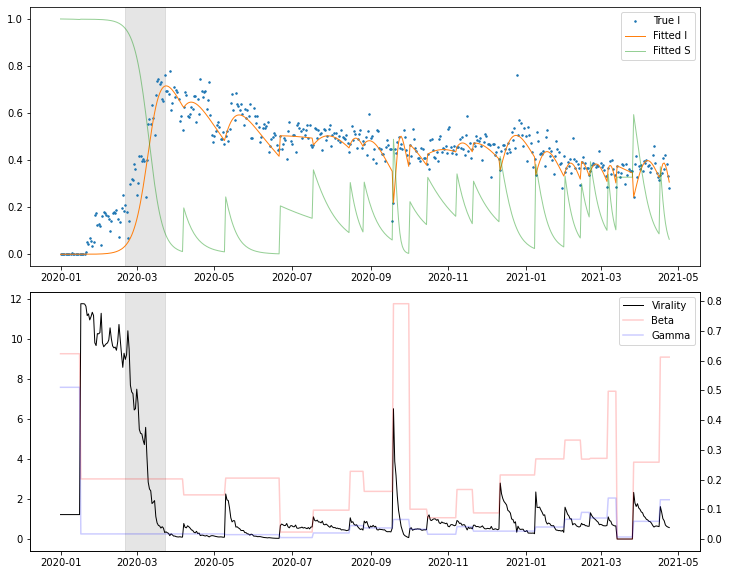

In [2]:
## Run the codes on the COVID news 
# import data

df = pd.read_excel('count_ratio.xlsx')
df_out = pd.DataFrame() 

# smoothen data for turning points detection
import statsmodels.api as sm
I_raw= df['ratio_bf'].tolist()
cycle, I_trend = sm.tsa.filters.hpfilter(I_raw, 10)
ydata = I_raw[:] #df['ratio_bf'].tolist()[9:]
xdata = np.linspace(0, len(ydata), len(ydata))

# find turning points
window = 5
turningpoints,turningscales = turning_points(I_trend,window)

dates = df['date'].tolist()

RT2,l_beta,l_gamma,l_sigma,S_3,I_3,R_3 = sir_turning (ydata,turningpoints,turningscales,sir_sigma_dgp)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
fig.subplots_adjust(hspace=0.1)

# to mark the crash period
from datetime import datetime
crashstart = datetime(2020, 2, 21) 
crashend = datetime(2020, 3, 23)

axes.flatten()[0].plot(dates,ydata, 'o', label="True I",markersize=1.5)

I = I_3
axes.flatten()[0].plot(dates,I, label="Fitted I",linewidth=1)
axes.flatten()[0].plot(dates,S_3, alpha=0.5,label="Fitted S",linewidth=1)
axes.flatten()[0].legend()
axes.flatten()[0].axvspan(crashstart, crashend, alpha=0.2, color='grey')

lns1 = axes.flatten()[1].plot(dates,RT2, color = 'black', label="Virality",linewidth=1)
axes.flatten()[1].axvspan(crashstart, crashend, alpha=0.2, color='grey')
ax2 = axes.flatten()[1].twinx()
lns2 = ax2.plot(dates,l_beta,alpha=0.2, label="Beta", color = 'red')
lns3 = ax2.plot(dates,l_gamma,alpha=0.2, label="Gamma",color = 'blue')
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
axes.flatten()[1].legend(lns, labs)

fig.savefig("Fig2.png")


